In [1]:
import numpy as np
from numba import njit
from functools import partial

import pandas as pd
import vectorbt as vbt
import vectorbt as vbt
from vectorbt.utils.colors import adjust_opacity
from vectorbt.utils.enum_ import map_enum_fields
from vectorbt.base.reshape_fns import broadcast, flex_select_auto_nb, to_2d_array
from vectorbt.portfolio.enums import SizeType, Direction, NoOrder, OrderStatus, OrderSide
from vectorbt.portfolio import nb

import talib 

import sys
import os
function_essential_path = r"H:\Desktop\Environement_Trading_Developement\FunctionEssential"
function_s_score_path = r'H:\Desktop\Environement_Trading_Developement\Indicateur'
sys.path.append(function_essential_path)
sys.path.append(function_s_score_path)
import utils as us
import s_score as score

In [ ]:
##FONCTION##

In [55]:
def entries_trades(close, s_score_ajusted, adx, seuil):
    entries_long = [False] * len(close)
    entries_short = [False] * len(close)
    level_zero = True

    for i in range(len(close)):
        # Vérifie si s_score_ajusted est proche de zéro


        if s_score_ajusted[i] >= seuil:
            for j in range(i, len(close) - 1):
                if s_score_ajusted[j] > s_score_ajusted[j + 1]:
                    if (adx.iloc[j+1] > 20):
                        break
                    else:
                        entries_short[j+1] = True
                        break
            level_zero = False

        if s_score_ajusted[i] <= -1 * seuil:
            for j in range(i, len(close) - 1):
                if s_score_ajusted[j] < s_score_ajusted[j + 1]:
                    if (adx.iloc[j+1] > 20):
                        break
                    else:
                        entries_long[j+1] = True
                        break
            level_zero = False

    return entries_long, entries_short

def exits_trades(long,short,close,high,low,sigma,mu,k):

    exits_long = [False] * len(close)
    exits_short = [False] * len(close)

    for i in range(len(close)):

        if long[i]:
            SL = close[i] * 0.98
            TP = close[i] * 1.03
            for j in range(i, len(close)):
                if  close[j] <= SL  or close[j] >= TP:
                    exits_long[j] = True
                    break

        if short[i]:  
            SL = close[i] * 1.02
            TP = close[i] * 0.97
            for j in range(i, len(close)):
                if  close[j] >= SL or close[j] <= TP:
                    exits_short[j] = True
                    break
    
    return exits_long,exits_short



In [ ]:
##INDICATEUR FACTORY##

In [58]:
##CLASS STRATEGIE##

@njit
def pre_sim_func_nb(c):
    entry_price = np.full(c.target_shape[1], np.nan, dtype=np.float64)  
    return (entry_price,)



@njit
def order_func_nb(c, entry_price, long, short, stop_loss, take_profit, size):
    price_now = nb.get_elem_nb(c, c.close)
    entry_long_now = nb.get_elem_nb(c, long)
    entry_short_now = nb.get_elem_nb(c, short)

    # Vérifie si nous devons entrer en position longue
    if entry_long_now:
        if c.position_now == 0:  # Aucune position ouverte
            return nb.order_nb(
                size,
                price=price_now,
                direction=Direction.LongOnly,
                fees=0.0005
                )
        elif c.position_now < 0:  # Position courte ouverte, on doit d'abord la fermer
            return nb.order_nb(
                size=-size,  # On ferme la position courte
                price=price_now,
                direction=Direction.ShortOnly,
                fees=0.0005
                )  # Puis, on ouvre une position longue

    # Vérifie si nous devons entrer en position courte
    if entry_short_now:
        if c.position_now == 0:  # Aucune position ouverte
            return nb.order_nb(
                size,
                price=price_now,
                direction=Direction.ShortOnly,
                fees=0.0005
                )
        elif c.position_now > 0:  # Position longue ouverte, on doit d'abord la fermer
            return nb.order_nb(
                size=-size,  # On ferme la position longue
                price=price_now,
                direction=Direction.LongOnly,
                fees=0.0005
                )  # Puis, on ouvre une position courte

    # Gestion des positions longues (on ferme la position si on atteint le stop-loss ou le take-profit)
    if c.position_now > 0:
        SL = entry_price[c.col] * (1 - stop_loss)
        TP = entry_price[c.col] * (1 + take_profit)
        
        if price_now >= TP:  # Si le prix atteint le TP, on ferme la position
            return nb.order_nb(
                -size,
                price=TP,
                direction=Direction.LongOnly,
                fees=0.0005
                )
        elif price_now <= SL:  # Si le prix atteint le SL, on ferme la position
            return nb.order_nb(
                -size,
                price=SL,
                direction=Direction.LongOnly,
                fees=0.0005
                )
    
    # Gestion des positions courtes (on ferme la position si on atteint le stop-loss ou le take-profit)
    if c.position_now < 0:
        SL = entry_price[c.col] * (1 + stop_loss)
        TP = entry_price[c.col] * (1 - take_profit)
        
        if price_now >= SL:  # Si le prix atteint le SL, on ferme la position
            return nb.order_nb(
                -size,
                price=SL,
                direction=Direction.ShortOnly)
        elif price_now <= TP:  # Si le prix atteint le TP, on ferme la position
            return nb.order_nb(
                -size,
                price=TP,
                direction=Direction.ShortOnly)

    return NoOrder

@njit
def post_order_func_nb(c, entry_price):
    if c.order_result.status == OrderStatus.Filled:
        entry_price[c.col] = c.order_result.price


class Strategie():
    def __init__(self, data, tickers, frequence_exec, frequence, multitimeframe):
        self.data = data
        self.tickers = tickers
        self.frequence_exec = frequence_exec
        self.frequences = frequence
        self.multitimeframe = multitimeframe   # Si 0 pas de multitimeframe si 1 multitimeframe

    def backtest(self, s_score):
        entries_long_df = pd.DataFrame()
        entries_short_df = pd.DataFrame()
        close_df = pd.DataFrame()

        for ticker in self.tickers:
            data = self.data[ticker]
            adx = talib.ADX(data['high'], data['low'], data['close'], timeperiod=14)

            # Calculer les signaux d'entrée
            long, short = entries_trades(data['close'], s_score[1], adx, 3)
            long = pd.Series(long, index=data['close'].index)  # Assurer que l'index est celui de close
            short = pd.Series(short, index=data['close'].index)  # Assurer que l'index est celui de close

            # Réinitialiser les index
            long = long.reset_index(drop=True)
            short = short.reset_index(drop=True)
            close = data['close'].reset_index(drop=True)
            stop_loss = 0.02
            take_profit = 0.03
            size = 1


            portfolio = vbt.Portfolio.from_order_func(
                close,
                order_func_nb,  # Fonction qui gère les ordres
                long.values,  # Signaux longs
                short.values,  # Signaux courts
                stop_loss,  # Stop loss
                take_profit,  # Take profit
                size,  # Taille des positions
                freq=self.frequence_exec,  # Fréquence d'exécution
                pre_sim_func_nb=pre_sim_func_nb,  # Fonction appelée avant la simulation
                post_order_func_nb=post_order_func_nb,  # Fonction appelée après chaque ordre
                broadcast_named_args=dict(  # Diffusion des arguments pour les fonctions
                    long=long,
                    short=short,
                    stop_loss=stop_loss,
                    take_profit=take_profit,
                    size=size
                )
            )

            # Enregistrer les résultats du portefeuille
            # us.generate_portfolio_report(portfolio, close)
            us.get_pnl(portfolio)
            us.generate_portfolio_report_order_function(portfolio, close)
            # Enregistrer les signaux d'entrée et de sortie dans des DataFrames
            entries_long_df[ticker] = long
            entries_short_df[ticker] = short
            close_df[ticker] = close

        # Pour les exits, tu peux également gérer les conditions de sortie ici si nécessaire
        return portfolio




In [49]:
##Initialisation##
tickers = ["USDJPY"]
data = us.get_data_forex(tickers,"H1")
USDJPY = data['USDJPY']
USDJPY_index = USDJPY.reset_index()
OU_process_out = score.mean_reversion(USDJPY['close'], USDJPY_index['Datetime'],85,"VOL", 0.5,"EGARCH")

Estimation des paramètres OU:   0%|          | 0/141145 [00:00<?, ?it/s]

  0%|          | 0/141145 [00:00<?, ?it/s]

Estimation des paramètres OU:   0%|          | 0/141145 [00:51<?, ?it/s]
H:\Desktop\Environement_Trading_Developement\Indicateur\s_score.py:31: RuntimeWarning:

invalid value encountered in sqrt

Calcul de la volatilité conditionnelle:   0%|          | 0/141230 [00:00<?, ?it/s]c:\Users\CYTech Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


Calcul de la volatilité conditionnelle: 100%|██████████| 141230/141230 [00:00<00:00, 237537.32it/s]


<Axes: >

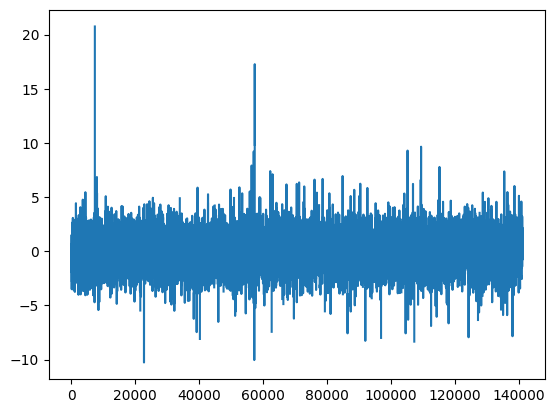

In [53]:
s_score = OU_process_out[1]

s_score = pd.Series(s_score)
s_score.plot()

In [ ]:
strat = Strategie(data,tickers,"60m","60m",0)
portfolio = strat.backtest(OU_process_out)
portfolio.plot().show()